# Add environmental data
This notebook is the code to add environmental data to the output of pypam
For more information about this process please contact clea.parcerisas@vliz.be or check the documentation of both packages
https://lifewatch-pypam.readthedocs.io/en/latest/
https://github.com/lifewatch/bpnsdata

In [4]:
# Install the required packages. Geopandas can give problems in Windows machines, so better to install them using wheels when using Windows
import sys
!{sys.executable} -m pip install --upgrade pip
!{sys.executable} -m pip install shapely==1.8.2
!{sys.executable} -m pip install git+https://github.com/paulfvliz/erddapy@localfile-fix
!{sys.executable} -m pip install bpnsdata==0.1.11
!{sys.executable} -m pip install pandas==1.4.2
!{sys.executable} -m pip install pygeos
!{sys.executable} -m pip install netcdf4
!{sys.executable} -m pip install scipy
!{sys.executable} -m pip install rasterio
!{sys.executable} -m pip install xarray

  Cloning https://github.com/paulfvliz/erddapy (to revision localfile-fix) to c:\users\cleap\appdata\local\temp\pip-req-build-aqp9dlwd
  Resolved https://github.com/paulfvliz/erddapy to commit 3b027a88732f2bd404d9a0df760823d7f6841e3e
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/paulfvliz/erddapy 'C:\Users\cleap\AppData\Local\Temp\pip-req-build-aqp9dlwd'
  Running command git checkout -b localfile-fix --track origin/localfile-fix
  branch 'localfile-fix' set up to track 'origin/localfile-fix'.
  Switched to a new branch 'localfile-fix'


  Using cached pandas-1.5.0-cp39-cp39-win_amd64.whl (10.9 MB)
  Attempting uninstall: pandas
    Found existing installation: pandas 2.0.2
    Uninstalling pandas-2.0.2:
      Successfully uninstalled pandas-2.0.2


ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\cleap\\Envs\\wadden_soundscape\\Lib\\site-packages\\~andas\\_libs\\algos.cp39-win_amd64.pyd'
Check the permissions.



In [1]:
import pathlib
import os

import geopandas
import pandas as pd
import xarray
from tqdm import tqdm

import bpnsdata

import erddapy 
print(erddapy.__version__)

C:\Users\cleap\Envs\wadden_soundscape\lib\site-packages\geopandas\_compat.py:124: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


1.2.2.dev1+g3b027a8


In [2]:
raw_data_path = pathlib.Path('./data/raw_data')
processed_data_path = pathlib.Path('./data/processed')
metadata_path = raw_data_path.joinpath('data_summary_mda.csv')
metadata = pd.read_csv(metadata_path, index_col=False)

if not processed_data_path.exists():
    os.mkdir(processed_data_path)

env_vars = [
		"shipping",
		"time",
		"bathymetry"
    ]


# Change this to the columns you add in the csv!
env_vars_from_csv = ['sediment_type', 'other_var', 'new_var']

In [3]:
metadata

,deployment_name,campaign,instrument_name,instrument_sensitivity,instrument_amp,instrument_Vpp,deployment_path,timezone,include_dirs,calibration,latitude,longitude,end_to_end_calibration,sediment_type,other_var,new_var
0,NLOyster1,1,SoundTrap,0,-170,2,0_NLOyster1.nc,UTC,0,-1,53.06843,4.88076,NaN,reef,1,a
1,NLOyster2,1,SoundTrap,0,-170,2,1_NLOyster2.nc,UTC,0,-1,53.06843,4.88076,NaN,reef,1,a
2,NLSand1,2,SoundTrap,0,-170,2,2_NLSand1.nc,UTC,0,-1,53.06843,5.20231,NaN,sand,2,a
3,NLSand2,2,SoundTrap,0,-160,2,3_NLSand2.nc,UTC,0,-1,53.06843,5.20231,NaN,sand,2,a


In [4]:
# Define the seadatamanager
manager = bpnsdata.SeaDataManager(env_vars)
id_name = 'id'
datetime_name = 'datetime'
for i, row in tqdm(metadata.iterrows(), total=len(metadata)):
    deployment_path = raw_data_path.joinpath('deployments', row['deployment_path'])
    env_path = processed_data_path.joinpath(row['deployment_path'].replace('.nc', '_env.nc'))
    print(env_path)
    if not env_path.exists():
        # Read the dataset
        ds_deployment = xarray.open_dataset(deployment_path, engine='netcdf4')
        # Get the time information from the dataset to get a pandas df
        datetime_index = ds_deployment[datetime_name].to_index()
        df = pd.DataFrame({"datetime": datetime_index.values, 'id': ds_deployment[id_name]})
        df = df.drop_duplicates("datetime")
        print(metadata.iloc[i]['deployment_name'], len(datetime_index), len(df))
        df.datetime = df.datetime.dt.tz_localize('UTC')

        df['latitude'] = row['latitude']
        df['longitude'] = row['longitude']

        # Generate the location information
        geodf = geopandas.GeoDataFrame(df, geometry=geopandas.points_from_xy(x=df['longitude'], y=df['latitude']), crs='EPSG:4326')
        geodf_env = manager(geodf, datetime_column='datetime')

        for env_var in env_vars_from_csv:
            geodf_env[env_var] = row[env_var]

        # Remove the UTC (xarray does not support it?)
        geodf_env.datetime = geodf_env.datetime.dt.tz_localize(None)
        lat = geodf_env['geometry'].y
        lon = geodf_env['geometry'].x
        df_env = geodf_env.drop(columns=['geometry', 'id'])
        env_ds = df_env.to_xarray()
        env_ds = env_ds.assign_coords(coords={'lat': lat, 'lon': lon, id_name : ('datetime', df.id.values)})
        env_ds = env_ds.swap_dims({'datetime': id_name})

        # Clean the previous if not all computed
        if len(env_ds[id_name]) != len(ds_deployment[id_name]):
            env_ds = env_ds.reindex_like(ds_deployment)
        new_ds = ds_deployment.merge(env_ds, compat="override")
        new_ds['season'] = new_ds[datetime_name].dt.isocalendar().week

        encoding = {'file_path': {'dtype': 'unicode'},
                    'start_sample': {'dtype': int, '_FillValue': -1},
                    'end_sample': {'dtype': int, '_FillValue': -1},
                    'datetime': {'dtype': float, '_FillValue': -1}}
        new_ds.to_netcdf(env_path,  encoding=encoding)
        print(new_ds)

  0%|          | 0/4 [00:00<?, ?it/s]

data\processed\0_NLOyster1_env.nc
NLOyster1 237 237


 25%|██▌       | 1/4 [00:05<00:17,  5.78s/it]

<xarray.Dataset>
Dimensions:                 (id: 237, frequency: 31, band: 1, index: 237,
                             dim_0: 237)
Coordinates: (12/17)
    file_path               (id) object ...
  * id                      (id) int32 0 1 2 3 4 5 6 ... 231 232 233 234 235 236
    start_sample            (id) int32 ...
    end_sample              (id) int32 ...
    datetime                (id) datetime64[ns] 2022-05-29T22:00:09 ... 2022-...
    hydrophone_sensitivity  (id) float64 ...
    ...                      ...
    low_freq                (band) int32 ...
    high_freq               (band) float64 ...
  * index                   (index) int64 0 1 2 3 4 5 ... 232 233 234 235 236
  * dim_0                   (dim_0) int64 0 1 2 3 4 5 ... 232 233 234 235 236
    lat                     (dim_0) float64 53.07 53.07 53.07 ... 53.07 53.07
    lon                     (dim_0) float64 4.881 4.881 4.881 ... 4.881 4.881
Data variables: (12/14)
    oct3                    (id, frequency) float

 50%|█████     | 2/4 [00:10<00:10,  5.31s/it]

<xarray.Dataset>
Dimensions:                 (id: 235, frequency: 31, band: 1, index: 235,
                             dim_0: 235)
Coordinates: (12/17)
    file_path               (id) object ...
  * id                      (id) int32 0 1 2 3 4 5 6 ... 229 230 231 232 233 234
    start_sample            (id) int32 ...
    end_sample              (id) int32 ...
    datetime                (id) datetime64[ns] 2022-05-30T17:10:08 ... 2022-...
    hydrophone_sensitivity  (id) float64 ...
    ...                      ...
    low_freq                (band) int32 ...
    high_freq               (band) float64 ...
  * index                   (index) int64 0 1 2 3 4 5 ... 230 231 232 233 234
  * dim_0                   (dim_0) int64 0 1 2 3 4 5 ... 230 231 232 233 234
    lat                     (dim_0) float64 53.07 53.07 53.07 ... 53.07 53.07
    lon                     (dim_0) float64 4.881 4.881 4.881 ... 4.881 4.881
Data variables: (12/14)
    oct3                    (id, frequency) float

 75%|███████▌  | 3/4 [00:15<00:05,  5.15s/it]

<xarray.Dataset>
Dimensions:                 (id: 235, frequency: 31, band: 1, index: 235,
                             dim_0: 235)
Coordinates: (12/17)
    file_path               (id) object ...
  * id                      (id) int32 0 1 2 3 4 5 6 ... 229 230 231 232 233 234
    start_sample            (id) int32 ...
    end_sample              (id) int32 ...
    datetime                (id) datetime64[ns] 2022-05-29T21:30:10 ... 2022-...
    hydrophone_sensitivity  (id) float64 ...
    ...                      ...
    low_freq                (band) int32 ...
    high_freq               (band) float64 ...
  * index                   (index) int64 0 1 2 3 4 5 ... 230 231 232 233 234
  * dim_0                   (dim_0) int64 0 1 2 3 4 5 ... 230 231 232 233 234
    lat                     (dim_0) float64 53.07 53.07 53.07 ... 53.07 53.07
    lon                     (dim_0) float64 5.202 5.202 5.202 ... 5.202 5.202
Data variables: (12/14)
    oct3                    (id, frequency) float

100%|██████████| 4/4 [00:21<00:00,  5.30s/it]

<xarray.Dataset>
Dimensions:                 (id: 233, frequency: 31, band: 1, index: 233,
                             dim_0: 233)
Coordinates: (12/17)
    file_path               (id) object ...
  * id                      (id) int32 0 1 2 3 4 5 6 ... 227 228 229 230 231 232
    start_sample            (id) int32 ...
    end_sample              (id) int32 ...
    datetime                (id) datetime64[ns] 2022-05-30T17:40:08 ... 2022-...
    hydrophone_sensitivity  (id) float64 ...
    ...                      ...
    low_freq                (band) int32 ...
    high_freq               (band) float64 ...
  * index                   (index) int64 0 1 2 3 4 5 ... 228 229 230 231 232
  * dim_0                   (dim_0) int64 0 1 2 3 4 5 ... 228 229 230 231 232
    lat                     (dim_0) float64 53.07 53.07 53.07 ... 53.07 53.07
    lon                     (dim_0) float64 5.202 5.202 5.202 ... 5.202 5.202
Data variables: (12/14)
    oct3                    (id, frequency) float

In [91]:
new_ds

<xarray.Dataset>
Dimensions:                 (id: 233, frequency: 31, band: 1, index: 233,
                             dim_0: 233)
Coordinates: (12/17)
    file_path               (id) object ...
  * id                      (id) int32 0 1 2 3 4 5 6 ... 227 228 229 230 231 232
    start_sample            (id) int32 ...
    end_sample              (id) int32 ...
    datetime                (id) datetime64[ns] 2022-05-30T17:40:08 ... 2022-...
    hydrophone_sensitivity  (id) float64 ...
    ...                      ...
    low_freq                (band) int32 ...
    high_freq               (band) float64 ...
  * index                   (index) int64 0 1 2 3 4 5 ... 228 229 230 231 232
  * dim_0                   (dim_0) int64 0 1 2 3 4 5 ... 228 229 230 231 232
    lat                     (dim_0) float64 53.07 53.07 53.07 ... 53.07 53.07
    lon                     (dim_0) float64 5.202 5.202 5.202 ... 5.202 5.202
Data variables: (12/13)
    oct3                    (id, frequency) float64 ...
    rms                     (id, band) float64 ...
    sel                     (id, band) float64 ...
    aci                     (id, band) float64 ...
    latitude                (index) float64 53.07 53.07 53.07 ... 53.07 53.07
    longitude               (index) float64 5.202 5.202 5.202 ... 5.202 5.202
    ...                      ...
    moon_phase              (index) float64 0.0492 0.04925 ... 1.767 1.767
    day_moment              (index) object 'Day' 'Day' 'Day' ... 'Day' 'Day'
    bathymetry              (index) float32 -1.555 -1.555 ... -1.555 -1.555
    sediment_type           (index) object 'sand' 'sand' ... 'sand' 'sand'
    other_var               (index) int64 2 2 2 2 2 2 2 2 2 ... 2 2 2 2 2 2 2 2
    season                  (id) int64 22 22 22 22 22 22 ... 23 23 23 23 23 23

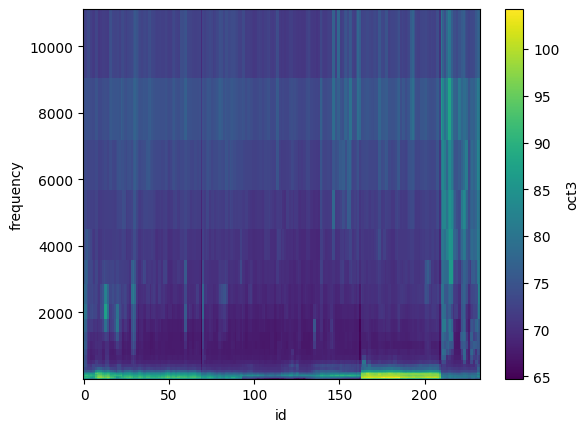

In [96]:
new_ds['oct3'].plot(x='id', y='frequency')

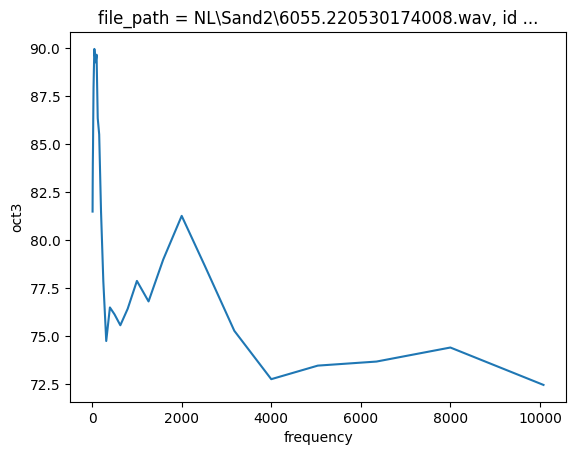

In [97]:
new_ds.sel(id=0)['oct3'].plot()